### Import Libraries:

In [ ]:
### IMPORT LIBRARIES ###

# General libraries for numerical operations, visualization, and warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Libraries for handling dates and file paths
import datetime
import os

# Optimization and hyperparameter tuning
import optuna
from optuna.trial import Trial

# Utility file for specific functions
import utilities as ut

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Data Preprocessing and Feature Engineering:

In [ ]:
# Load dataset and prepare features and target variables
file_path = r"C:\Users\LOMBARDI\EOLIC\Data\df_5min.csv"
parque_eolico = "TETE"
aero = "TETE-WTG05"

# Configuration for time series window and forecast
window = 36               # 180 min
forecast_horizon = 1      # Predict 1 timestamp
offset = 1

# Define feature and target columns
features = ['Temperatura Ambiente','Frecuencia','x_wind','y_wind']
target = ['Potencia Activa']

first_split = 0.7
second_split = 0.9

In [ ]:
# # Load the new dataset from the specified CSV file path
df = pd.read_csv(file_path, header=0, index_col=0)

# Reset the index to make 'Fecha' a column, and rename 'TimeStamp' to 'Fecha' for consistency
df=df.reset_index()
df.rename(columns={'TimeStamp': 'Fecha'}, inplace=True)

# Convert the 'Fecha' column to a datetime object for easier manipulation later
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%Y-%m-%d %H:%M:%S")

# Filter the data to include only rows for the selected wind turbine (aero)
df2 = df.loc[df["WTGTemplate"] == aero]

# Select the relevant columns for further analysis
df2 = df2[["Fecha", 
             "Potencia Activa",
             "Velocidad de Viento",
             "Dirección de viento", 
             "Temperatura Ambiente",
             "Frecuencia" 
             ]]

# Filter out rows where the 'Potencia Activa' (Active Power) is 0 or below
df3 = df2[df2["Potencia Activa"] > 0]

# Handle missing values by forward filling them
df3 = df3.fillna(method="ffill")

# Decompose the 'Velocidad de Viento' (Wind Speed) into its x and y components based on the wind direction
wv = df3['Velocidad de Viento']
wd_rad = df3['Dirección de viento']*np.pi / 180

df3['x_wind'] = wv*np.cos(wd_rad)
df3['y_wind'] = wv*np.sin(wd_rad)

# Select only the relevant columns for the analysis
df4 = df3[['Fecha', 'Potencia Activa','Temperatura Ambiente', 'Frecuencia', 'x_wind','y_wind']]

# Set the 'Fecha' column as the index for time series analysis
df4.set_index('Fecha', inplace=True)    

In [ ]:
# Generate a supervised dataset
X, y = ut.supervised_dataset(df4, window, forecast_horizon, offset, features, target)

In [ ]:
# Split the data into training, validation, and testing sets
X_train, y_train, X_val, y_val, X_test, y_test = ut.train_val_test_split(X, y, first_split, second_split)

### Standarization:

In [ ]:
### STANDARIZATION: 
# StandardScaler standardizes the features by removing the mean and scaling to unit variance.

# SCALE INPUT 
# Initialize a scaler for the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# SCALE TARGET 
# Initialize a separate scaler for the target variable
scaler_target = StandardScaler()
y_train = scaler_target.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_val = scaler_target.transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)

# Note: We do not scale the test target values here since they are usually compared in their original scale after predictions are made.

### Optuna Hyperparameter Optimization:

In [ ]:
def objective(trial):
    """
    Objective function for Optuna, which optimizes hyperparameters for an LSTM model.
    """
    # Hyperparameters to be optimized by Optuna:
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-2)  # Learning rate on a logarithmic scale
    epochs = trial.suggest_int('epochs', 10, 100)  # Number of epochs
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])  # Batch size

    # Define the LSTM model architecture:
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(1))  # Final dense layer for the output

    # Compile the model with Adam optimizer and Mean Squared Error loss:
    model.compile(Adam(learning_rate=lr), loss="mse")

    # Early stopping to prevent overfitting:
    es = EarlyStopping(
        patience=8,  # Number of epochs to wait after no improvement
        min_delta=0.001,  # Minimum change in loss to qualify as an improvement
        monitor='val_loss',  # Monitor validation loss
        mode='auto',
        restore_best_weights=True,  # Restore the best model weights
        verbose=0  # Suppress logs for brevity
    )

    # Train the model using the training and validation sets:
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[es]
    )

    # Return the final validation loss as the metric to minimize:
    val_loss = history.history['val_loss'][-1]  # Last value of validation loss
    return val_loss

### Model Training and Prediction with Best Hyperparameters:

In [ ]:
# Measure execution time:
start_time = time.time()

# Create an Optuna study to minimize the objective function:
study = optuna.create_study(direction='minimize')

# Run the optimization for 10 trials:
study.optimize(objective, n_trials=10)

# Extract the best hyperparameters:
best_params = study.best_params

# Build the final model with the best hyperparameters:
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

# Compile the final model:
model.compile(Adam(learning_rate=best_params['lr']), loss="mse")

# Early stopping for the final training:
es = EarlyStopping(
    patience=8,
    min_delta=0.001,
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True,
    verbose=0
)

# Train the final model with the best hyperparameters:
history = model.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[es]
)

# Evaluate final validation loss:
val_loss = history.history['val_loss'][-1]

# Generate predictions for the test set:
predictions = model.predict(X_test)

# Inverse transform the scaled predictions to the original scale:
pred_raw = scaler_target.inverse_transform(predictions.reshape(-1, predictions.shape[-1])).reshape(predictions.shape)

# Generate and inverse transform validation predictions:
predictions_val = model.predict(X_val)
pred_raw_val = scaler_target.inverse_transform(predictions_val.reshape(-1, predictions_val.shape[-1])).reshape(predictions_val.shape)

# Inverse transform the scaled validation target values:
y_val_raw = scaler_target.inverse_transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)

# Measure total execution time:
end_time = time.time()

# Calculate elapsed time in minutes and hours:
elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60
elapsed_hours = elapsed_minutes / 60

# Print execution time:
print(f"\n\nTiempo de ejecución : {elapsed_minutes:.2f} minutos ({elapsed_hours:.2f} horas)")

[I 2024-06-13 10:00:54,307] A new study created in memory with name: no-name-a6fd3c68-4894-4625-9d6c-8cac93c72567


Epoch 1/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 373s 654ms/step - loss: 0.4290 - val_loss: 0.1741
Epoch 2/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 331s 561ms/step - loss: 0.1444 - val_loss: 0.1390
Epoch 3/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 267s 461ms/step - loss: 0.1203 - val_loss: 0.1293
Epoch 4/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 273s 480ms/step - loss: 0.1185 - val_loss: 0.1279
Epoch 5/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 314s 464ms/step - loss: 0.1122 - val_loss: 0.1269
Epoch 6/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 286s 507ms/step - loss: 0.1118 - val_loss: 0.1390
Epoch 7/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 379s 608ms/step - loss: 0.1087 - val_loss: 0.1238
Epoch 8/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 374s 592ms/step - loss: 0.1068 - val_loss: 0.1231
Epoch 9/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 348s 529ms/step - loss: 0.1062 - val_loss: 0.1226
Epoch 10/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 284s 517ms/step - loss: 0.1063 - val_loss: 0.1223
Epoch 11/92
550/550 ━━━━━━━━━━━━━━━━━━━━ 309s 492ms/step - loss: 0.1038 - val_loss: 0.1259
Epoch 12

[I 2024-06-13 12:10:27,537] Trial 0 finished with value: 0.12096806615591049 and parameters: {'lr': 0.0003201767801530817, 'epochs': 92, 'batch_size': 256}. Best is trial 0 with value: 0.12096806615591049.


Epoch 1/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 388s 334ms/step - loss: 0.8696 - val_loss: 0.4333
Epoch 2/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 495s 436ms/step - loss: 0.3649 - val_loss: 0.3323
Epoch 3/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 397s 361ms/step - loss: 0.2816 - val_loss: 0.2849
Epoch 4/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 394s 358ms/step - loss: 0.2407 - val_loss: 0.2464
Epoch 5/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 359s 327ms/step - loss: 0.2081 - val_loss: 0.2203
Epoch 6/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 362s 308ms/step - loss: 0.1881 - val_loss: 0.2014
Epoch 7/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 423s 344ms/step - loss: 0.1746 - val_loss: 0.1939
Epoch 8/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 378s 343ms/step - loss: 0.1657 - val_loss: 0.1848
Epoch 9/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 364s 326ms/step - loss: 0.1584 - val_loss: 0.1760
Epoch 10/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 337s 307ms/step - loss: 0.1511 - val_loss: 0.1675
Epoch 11/64
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 389s 312ms/step - loss: 0.1464 - val

[I 2024-06-13 17:12:47,125] Trial 1 finished with value: 0.1287478655576706 and parameters: {'lr': 1.4734773817684156e-05, 'epochs': 64, 'batch_size': 128}. Best is trial 0 with value: 0.12096806615591049.


Epoch 1/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 280s 244ms/step - loss: 0.4869 - val_loss: 0.1261
Epoch 2/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 335s 256ms/step - loss: 0.1140 - val_loss: 0.1239
Epoch 3/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 362s 291ms/step - loss: 0.1098 - val_loss: 0.1278
Epoch 4/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 296s 267ms/step - loss: 0.1075 - val_loss: 0.1223
Epoch 5/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 294s 241ms/step - loss: 0.1081 - val_loss: 0.1239
Epoch 6/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 341s 257ms/step - loss: 0.1061 - val_loss: 0.1201
Epoch 7/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 276s 215ms/step - loss: 0.1051 - val_loss: 0.1259
Epoch 8/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 255s 208ms/step - loss: 0.1052 - val_loss: 0.1208
Epoch 9/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 273s 218ms/step - loss: 0.1062 - val_loss: 0.1204
Epoch 10/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 289s 243ms/step - loss: 0.1036 - val_loss: 0.1228
Epoch 11/48
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 312s 233ms/step - loss: 21929230.000

[I 2024-06-13 18:21:00,276] Trial 2 finished with value: 14.51263427734375 and parameters: {'lr': 0.005399902310149405, 'epochs': 48, 'batch_size': 128}. Best is trial 0 with value: 0.12096806615591049.


Epoch 1/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 202s 629ms/step - loss: 0.9902 - val_loss: 0.9121
Epoch 2/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 196s 612ms/step - loss: 0.9307 - val_loss: 0.7897
Epoch 3/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 222s 684ms/step - loss: 0.7604 - val_loss: 0.5657
Epoch 4/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 192s 644ms/step - loss: 0.5672 - val_loss: 0.4853
Epoch 5/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 192s 609ms/step - loss: 0.4706 - val_loss: 0.4446
Epoch 6/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 240s 747ms/step - loss: 0.4189 - val_loss: 0.4076
Epoch 7/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 219s 591ms/step - loss: 0.3826 - val_loss: 0.3788
Epoch 8/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 203s 595ms/step - loss: 0.3458 - val_loss: 0.3580
Epoch 9/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 203s 598ms/step - loss: 0.3288 - val_loss: 0.3440
Epoch 10/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 203s 599ms/step - loss: 0.3142 - val_loss: 0.3300
Epoch 11/92
275/275 ━━━━━━━━━━━━━━━━━━━━ 201s 593ms/step - loss: 0.2975 - val_loss: 0.3222
Epoch 12

[I 2024-06-13 23:29:36,590] Trial 3 finished with value: 0.14383769035339355 and parameters: {'lr': 7.554211507033451e-06, 'epochs': 92, 'batch_size': 512}. Best is trial 0 with value: 0.12096806615591049.


Epoch 1/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 281s 235ms/step - loss: 0.9437 - val_loss: 0.7155
Epoch 2/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 251s 224ms/step - loss: 0.6980 - val_loss: 0.5212
Epoch 3/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 264s 225ms/step - loss: 0.5165 - val_loss: 0.4641
Epoch 4/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 259s 222ms/step - loss: 0.4083 - val_loss: 0.3964
Epoch 5/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 264s 224ms/step - loss: 0.3424 - val_loss: 0.3524
Epoch 6/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 262s 224ms/step - loss: 0.3097 - val_loss: 0.3298
Epoch 7/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 269s 230ms/step - loss: 0.2886 - val_loss: 0.3195
Epoch 8/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 268s 235ms/step - loss: 0.2772 - val_loss: 0.3052
Epoch 9/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 252s 226ms/step - loss: 0.2663 - val_loss: 0.2956
Epoch 10/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 263s 227ms/step - loss: 0.2521 - val_loss: 0.2852
Epoch 11/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 265s 230ms/step - loss: 0.2447 - val

[I 2024-06-14 02:34:22,217] Trial 4 finished with value: 0.1520260125398636 and parameters: {'lr': 6.030733757860127e-06, 'epochs': 41, 'batch_size': 128}. Best is trial 0 with value: 0.12096806615591049.


Epoch 1/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 245s 849ms/step - loss: 0.9928 - val_loss: 0.9068
Epoch 2/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 205s 654ms/step - loss: 0.9348 - val_loss: 0.8053
Epoch 3/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 203s 656ms/step - loss: 0.8035 - val_loss: 0.6188
Epoch 4/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 202s 655ms/step - loss: 0.6141 - val_loss: 0.5045
Epoch 5/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 200s 647ms/step - loss: 0.5021 - val_loss: 0.4353
Epoch 6/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 202s 645ms/step - loss: 0.4061 - val_loss: 0.3836
Epoch 7/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 211s 675ms/step - loss: 0.3479 - val_loss: 0.3537
Epoch 8/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 195s 649ms/step - loss: 0.3194 - val_loss: 0.3320
Epoch 9/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 203s 653ms/step - loss: 0.3022 - val_loss: 0.3150
Epoch 10/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 202s 652ms/step - loss: 0.2800 - val_loss: 0.2951
Epoch 11/95
275/275 ━━━━━━━━━━━━━━━━━━━━ 210s 680ms/step - loss: 0.2638 - val_loss: 0.2845
Epoch 12

[I 2024-06-14 07:55:10,643] Trial 5 finished with value: 0.1370338350534439 and parameters: {'lr': 7.189586174525737e-06, 'epochs': 95, 'batch_size': 512}. Best is trial 0 with value: 0.12096806615591049.


Epoch 1/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 271s 456ms/step - loss: 0.9185 - val_loss: 0.5059
Epoch 2/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 260s 453ms/step - loss: 0.4109 - val_loss: 0.3154
Epoch 3/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 268s 463ms/step - loss: 0.2748 - val_loss: 0.2715
Epoch 4/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 244s 430ms/step - loss: 0.2366 - val_loss: 0.2452
Epoch 5/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 261s 428ms/step - loss: 0.2097 - val_loss: 0.2142
Epoch 6/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 265s 432ms/step - loss: 0.1884 - val_loss: 0.1978
Epoch 7/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 285s 473ms/step - loss: 0.1690 - val_loss: 0.1816
Epoch 8/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 256s 462ms/step - loss: 0.1574 - val_loss: 0.1689
Epoch 9/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 294s 519ms/step - loss: 0.1479 - val_loss: 0.1622
Epoch 10/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 301s 480ms/step - loss: 0.1404 - val_loss: 0.1584
Epoch 11/89
550/550 ━━━━━━━━━━━━━━━━━━━━ 358s 544ms/step - loss: 0.1355 - val_loss: 0.1532
Epoch 12

[I 2024-06-14 12:35:56,718] Trial 6 finished with value: 0.12622655928134918 and parameters: {'lr': 2.135378082002259e-05, 'epochs': 89, 'batch_size': 256}. Best is trial 0 with value: 0.12096806615591049.


Epoch 1/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 371s 638ms/step - loss: 0.8944 - val_loss: 0.4997
Epoch 2/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 342s 565ms/step - loss: 0.4239 - val_loss: 0.3237
Epoch 3/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 391s 689ms/step - loss: 0.2797 - val_loss: 0.2816
Epoch 4/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 373s 679ms/step - loss: 0.2434 - val_loss: 0.2517
Epoch 5/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 406s 721ms/step - loss: 0.2176 - val_loss: 0.2326
Epoch 6/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 368s 584ms/step - loss: 0.1984 - val_loss: 0.2170
Epoch 7/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 325s 589ms/step - loss: 0.1873 - val_loss: 0.2012
Epoch 8/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 394s 611ms/step - loss: 0.1753 - val_loss: 0.1971
Epoch 9/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 412s 663ms/step - loss: 0.1649 - val_loss: 0.1822
Epoch 10/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 409s 712ms/step - loss: 0.1589 - val_loss: 0.1767
Epoch 11/26
550/550 ━━━━━━━━━━━━━━━━━━━━ 407s 647ms/step - loss: 0.1513 - val_loss: 0.1689
Epoch 12

[I 2024-06-14 15:24:15,571] Trial 7 finished with value: 0.13856574892997742 and parameters: {'lr': 2.3664313796624894e-05, 'epochs': 26, 'batch_size': 256}. Best is trial 0 with value: 0.12096806615591049.


Epoch 1/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 667s 586ms/step - loss: 0.2511 - val_loss: 0.1356
Epoch 2/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 539s 456ms/step - loss: 0.1136 - val_loss: 0.1215
Epoch 3/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 435s 395ms/step - loss: 0.1084 - val_loss: 0.1221
Epoch 4/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 526s 471ms/step - loss: 0.1080 - val_loss: 0.1195
Epoch 5/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 559s 467ms/step - loss: 0.1060 - val_loss: 0.1213
Epoch 6/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 581s 484ms/step - loss: 0.1058 - val_loss: 0.1232
Epoch 7/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 584s 503ms/step - loss: 0.1062 - val_loss: 0.1192
Epoch 8/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 548s 489ms/step - loss: 0.1034 - val_loss: 0.1184
Epoch 9/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 543s 471ms/step - loss: 0.1034 - val_loss: 0.1192
Epoch 10/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 546s 456ms/step - loss: 0.1029 - val_loss: 0.1186
Epoch 11/91
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 551s 500ms/step - loss: 0.1013 - val

[I 2024-06-14 17:51:18,151] Trial 8 finished with value: 0.1253073513507843 and parameters: {'lr': 0.0016428022959296788, 'epochs': 91, 'batch_size': 128}. Best is trial 0 with value: 0.12096806615591049.


Epoch 1/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 577s 463ms/step - loss: 0.2872 - val_loss: 0.1246
Epoch 2/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 500s 454ms/step - loss: 0.1140 - val_loss: 0.1248
Epoch 3/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 431s 390ms/step - loss: 0.1109 - val_loss: 0.1199
Epoch 4/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 437s 385ms/step - loss: 0.1078 - val_loss: 0.1273
Epoch 5/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 487s 425ms/step - loss: 0.1076 - val_loss: 0.1246
Epoch 6/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 494s 417ms/step - loss: 0.1067 - val_loss: 0.1294
Epoch 7/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 505s 420ms/step - loss: 0.1057 - val_loss: 0.1242
Epoch 8/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 463s 383ms/step - loss: 0.1039 - val_loss: 0.1209
Epoch 9/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 423s 385ms/step - loss: 0.1042 - val_loss: 0.1243
Epoch 10/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 439s 382ms/step - loss: 0.1042 - val_loss: 0.1194
Epoch 11/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 501s 435ms/step - loss: 0.1013 - val

[I 2024-06-14 19:19:09,902] Trial 9 finished with value: 0.12019126862287521 and parameters: {'lr': 0.0029723343091547427, 'epochs': 41, 'batch_size': 128}. Best is trial 9 with value: 0.12019126862287521.


Epoch 1/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 535s 473ms/step - loss: 0.2437 - val_loss: 0.1224
Epoch 2/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 484s 403ms/step - loss: 0.1105 - val_loss: 0.1299
Epoch 3/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 495s 396ms/step - loss: 0.1089 - val_loss: 0.1273
Epoch 4/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 503s 451ms/step - loss: 0.1079 - val_loss: 0.1222
Epoch 5/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 468s 419ms/step - loss: 0.1077 - val_loss: 0.1205
Epoch 6/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 527s 441ms/step - loss: 0.1059 - val_loss: 0.1252
Epoch 7/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 474s 416ms/step - loss: 0.1050 - val_loss: 0.1234
Epoch 8/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 472s 388ms/step - loss: 0.1026 - val_loss: 0.1198
Epoch 9/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 439s 385ms/step - loss: 0.1028 - val_loss: 0.1195
Epoch 10/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 445s 387ms/step - loss: 0.1024 - val_loss: 0.1217
Epoch 11/41
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 485s 441ms/step - loss: 0.1022 - val

### Results:

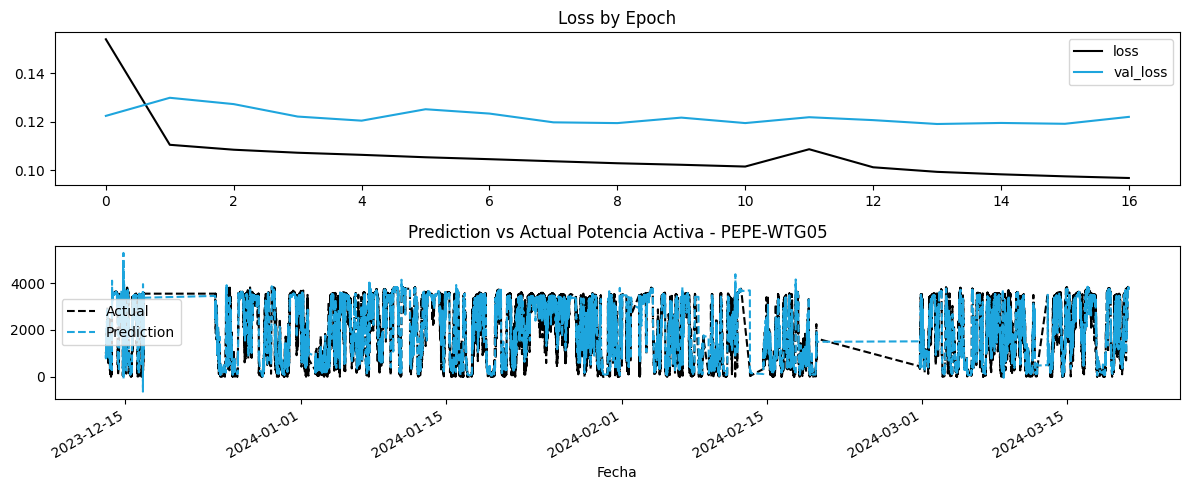

In [ ]:
# Create an index for the test dates
dates_test = pd.Index(df4.index[-len(y_test):])

# Plot the forecasted values
ut.plot_forecast(y_test, pred_raw, dates_test, history, aero)

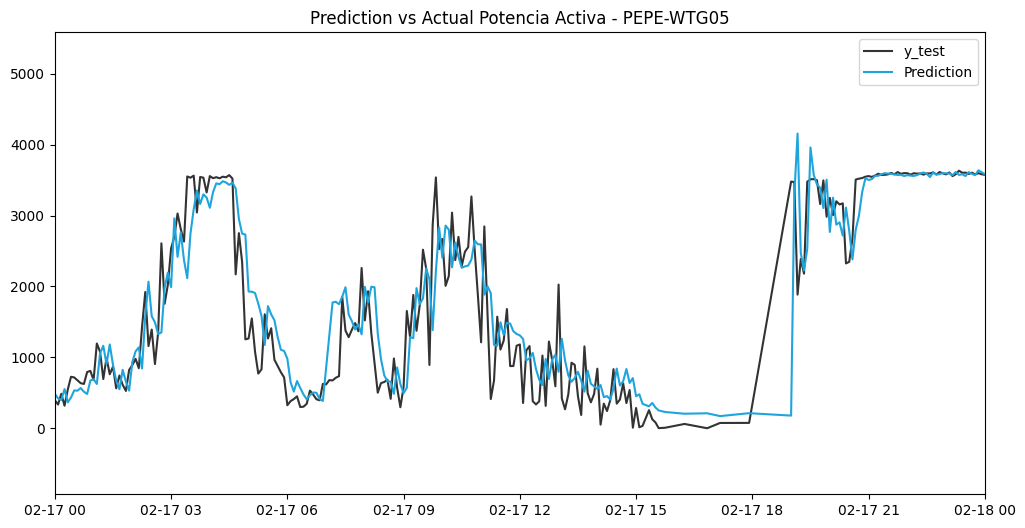

In [ ]:
dates_test = df4.index[-len(y_test):]

start = datetime.datetime(2024, 2, 17) 
end = datetime.datetime(2024, 2, 18) 

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.flatten(), c='black', alpha=0.8, label='y_test')
plt.plot(dates_test, pred_raw.flatten(), color=(30/255, 165/255, 221/255), label="Prediction")
plt.title(f'Prediction vs Actual Potencia Activa - {aero}')
plt.xlim([start, end])
plt.legend()

### Model Evaluation Metrics:


In [ ]:
# Evaluate the model's performance using test and validation data
ut.test_val_metrics(y_test, pred_raw, y_val_raw, pred_raw_val)

Test:
  MSE: 247415.88
  RMSE: 497.41
  MAE: 326.93
  R^2: 0.86
Validation:
  MSE: 224831.29
  RMSE: 474.16
  MAE: 306.87
  R^2: 0.87


In [ ]:
model.save(r"C:\Users\LOMBARDI\EOLIC\modelo_lstm.h5")


df4 min: 2021-12-02 00:05:00

df4 max: 2024-03-21 00:00:00

### New Data Prediction Period:

In [ ]:
# Specify the file path of the new CSV file containing the data
file_path_new = r"C:\Users\LOMBARDI\EOLIC\Data\df_5min_nuevo.csv"

# Set the start date for the prediction period
start_date = '2024-05-01'    # 'YYYY-MM-DD' format

# Set the end date for the prediction period
end_date = '2024-05-31'      # 'YYYY-MM-DD' format

###  Data Preprocessing and Feature Engineering:

In [ ]:
# Load the new dataset 
df_new = pd.read_csv(file_path_new, header=0, index_col=0)

# Reset the index to make 'Fecha' a column, and rename 'TimeStamp' to 'Fecha' for consistency
df_new = df_new.reset_index()
df_new.rename(columns={'TimeStamp': 'Fecha'}, inplace=True)

# Convert the 'Fecha' column to a datetime object for easier manipulation later
df_new['Fecha'] = pd.to_datetime(df_new['Fecha'], format="%Y-%m-%d %H:%M:%S")

# Filter the data to include only rows for the selected wind turbine (aero)
df_new = df_new.loc[df_new["WTGTemplate"] == aero]

# Select the relevant columns for further analysis
df_new = df_new[["Fecha", 
                 "Potencia Activa",  # Active Power
                 "Velocidad de Viento",  # Wind Speed
                 "Dirección de viento",  # Wind Direction
                 "Temperatura Ambiente",  # Ambient Temperature
                 "Frecuencia"]]  # Frequency

# Filter out rows where the 'Potencia Activa' is 0 or below
df_new = df_new[df_new["Potencia Activa"] > 0]

# Handle missing values by forward filling them
df_new = df_new.fillna(method="ffill")

# Decompose the 'Velocidad de Viento' (Wind Speed) into its x and y components based on the wind direction
wv = df_new['Velocidad de Viento']  
wd_rad = df_new['Dirección de viento'] * np.pi / 180  # Convert wind direction to radians

# Calculate the x and y components of the wind velocity
df_new['x_wind'] = wv * np.cos(wd_rad)
df_new['y_wind'] = wv * np.sin(wd_rad)

# Select only the relevant columns for the analysis
df_new = df_new[['Fecha', 'Potencia Activa', 'Temperatura Ambiente', 'Frecuencia', 'x_wind', 'y_wind']]

# Set the 'Fecha' column as the index for time series analysis
df_new.set_index('Fecha', inplace=True)

### Filtering Data by Date Range for Forecasting:

In [ ]:
# Convert the provided start_date to a pandas Timestamp object
# and adjust it to the desired start date by subtracting the time window in minutes
new_start = pd.Timestamp(start_date) - pd.DateOffset(minutes=window*5)

# Filter the df_new dataframe to include only the rows between the adjusted start date (new_start) and the end date (end_date)
# This ensures that the data starts from a time point before the prediction window, based on the window size
df_new_dates = df_new.loc[new_start:end_date]

In [24]:
df_new_dates.head(37)

,Potencia Activa,Temperatura Ambiente,Frecuencia,x_wind,y_wind
Fecha,,,,,
2024-04-30 21:00:00,1481.259155,16.0,50.024818,0.924490,-7.140400
2024-04-30 21:05:00,1754.257568,16.0,50.023876,1.538792,-7.746035
2024-04-30 21:10:00,1439.730713,17.0,50.022934,1.354442,-7.599240
2024-04-30 21:15:00,1111.098511,16.0,50.021992,1.780639,-6.104605
2024-04-30 21:20:00,1350.173584,16.0,50.021049,1.308914,-7.288418
2024-04-30 21:25:00,1289.455811,16.0,50.020107,1.072857,-7.468373
2024-04-30 21:30:00,1581.925171,16.0,50.019165,1.650385,-6.100870
2024-04-30 21:35:00,1762.680420,16.0,50.018223,2.117204,-7.357722
2024-04-30 21:40:00,1351.259155,17.0,50.017281,1.234983,-7.051346


In [ ]:
# Generate the supervised learning dataset
X_mayo, y_mayo = ut.supervised_dataset(df_new_dates, window, forecast_horizon, offset, features, target)

In [ ]:
### STANDARIZATION: 
# Standardization of input features for model training.
scaler = StandardScaler()
X_mayo = scaler.fit_transform(X_mayo.reshape(-1, X_mayo.shape[-1])).reshape(X_mayo.shape)

In [ ]:
# Predicting the target variable (Active Power) using the trained model
predictions_mayo = model.predict(X_mayo)

# Inverse standardization of the predictions:
# The predictions need to be converted back to their original scale (descaled).
pred_raw_mayo = scaler_target.inverse_transform(predictions_mayo.reshape(-1, predictions_mayo.shape[-1])).reshape(predictions_mayo.shape)

238/238 ━━━━━━━━━━━━━━━━━━━━ 39s 122ms/step


### Results:

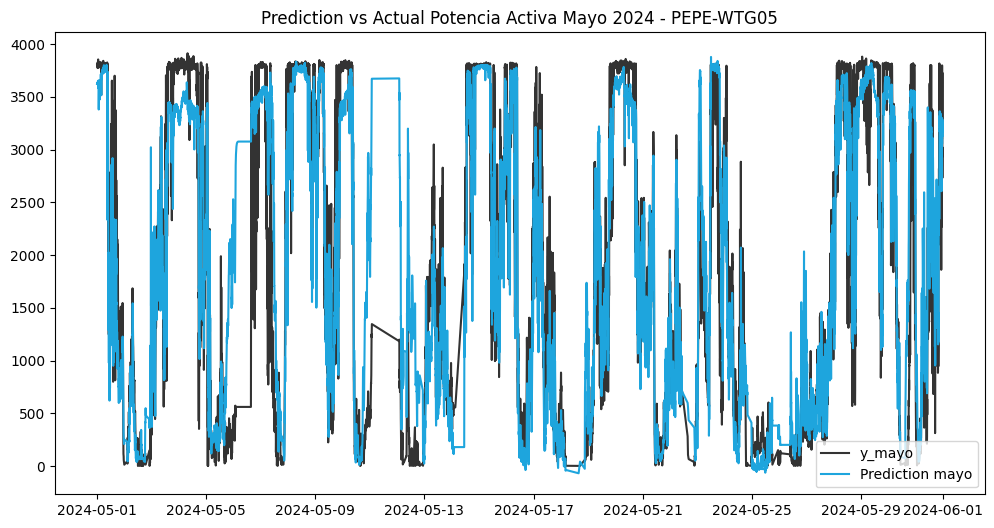

In [41]:
dates_test = pd.Index(df_new_dates.index[-len(y_mayo):])

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_mayo.flatten(), c='black', alpha=0.8, label='y_mayo')
plt.plot(dates_test, pred_raw_mayo.flatten(), color=(30/255, 165/255, 221/255), label="Prediction mayo")
plt.title(f'Prediction vs Actual Potencia Activa Mayo 2024 - {aero}')

plt.legend()

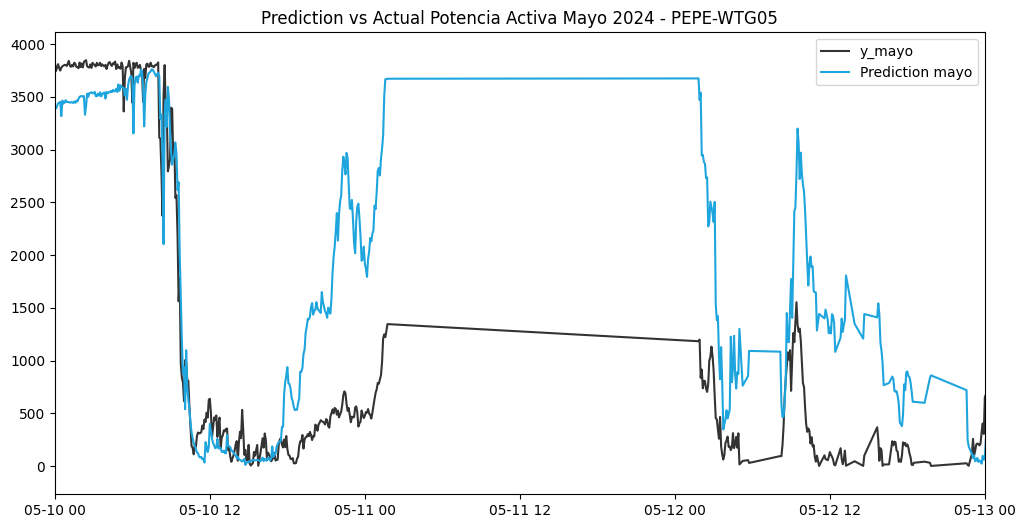

In [54]:
start = datetime.datetime(2024, 5, 10) 
end = datetime.datetime(2024, 5, 13) 

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_mayo.flatten(), c='black', alpha=0.8, label='y_mayo')
plt.plot(dates_test, pred_raw_mayo.flatten(), color=(30/255, 165/255, 221/255), label="Prediction mayo")
plt.title(f'Prediction vs Actual Potencia Activa Mayo 2024 - {aero}')
plt.xlim([start, end])
plt.legend()

### Energy Prediction Comparison for May:


In [ ]:
# Print the total predicted energy for May (sum of the predictions):
print(f"Prediccion Energía Mayo: {np.sum(pred_raw_mayo):.2f}")

# Print the actual energy for May (sum of the actual values in y_mayo):
print(f"Energía Mayo: {np.sum(y_mayo):.2f}")

Prediccion Energía Mayo: 14937336.00
Energía Mayo: 14406818.86
